In [1]:
from __future__ import print_function

%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from datetime import datetime, timedelta
from IPython.display import HTML

from model import Classifier

In [2]:
# Set random seed for reproducibility
manualSeed = 999

In [3]:
random.seed(manualSeed)
torch.manual_seed(manualSeed)

## Hyperparameters

In [4]:
restore_session = True

# Dataset and dataloader
dataroot = "data_small"
image_size = 256
workers = 2
batch_size = 128

# Training parameters
n_epochs = 5
lr = 0.001
momentum = 0.9
ngpu = 1

In [5]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

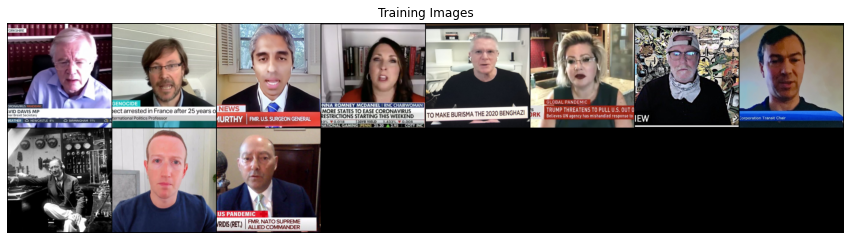

In [7]:
fixed_batch = next(iter(dataloader))
plt.figure(figsize=(15,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fixed_batch[0].to(device)[:64], padding=2,normalize=True).cpu(),(1,2,0)))
plt.show()

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
classifier = Classifier().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    classifier = nn.DataParallel(classifier, list(range(ngpu)))
classifier.apply(weights_init)

Classifier(
  (convolve): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(4, 4))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=3456, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=lr, momentum=momentum)

In [11]:
class_progress = []
loss_history = []
iters, start_epoch = 0, 0

runtime = ''
start_time = datetime.now()

In [12]:
def print_progress(line):
    with open('out.txt', 'w') as file:
        file.write(line)

In [13]:
def save_session(cur_epoch, cur_iters, cur_time, loss, progress):
    model_state = { 'state_dict': classifier.state_dict(), 'optimizer': optimizer.state_dict() }
    log_state = { 'iters': cur_iters, 'epoch': cur_epoch + 1, 'runtime': cur_time,
                    'loss': loss, 'progress': progress }
    state = { 'model_state': model_state, 'log_state': log_state }
    torch.save(state, 'checkpoints/latest.pth.tar')

In [14]:
def load_session(filename='checkpoints/latest.pth.tar'):
    if os.path.isfile(filename):
        print('=> Loading checkpoint from {}'.format(filename))
        checkpoint = torch.load(filename)
        return checkpoint
    else:
        print('=> Checkpoint {} not found'.format(filename))

In [15]:
if os.path.isfile('checkpoints//latest.pth.tar') and restore_session:
    session = load_session('checkpoints/latest.pth.tar')

    # Load logs
    loss_history = session['log_state']['loss']
    class_progress = session['log_state']['progress']
    iters, start_epoch = session['log_state']['iters'], session['log_state']['epoch']
    runtime = session['log_state']['runtime']

    # Load model
    classifier.load_state_dict(session['model_state']['state_dict'])
    optimizer.load_state_dict(session['model_state']['optimizer'])

    dt = datetime.strptime(runtime, '%H:%M:%S')
    runtime_delta = timedelta(hours=dt.hour, minutes=dt.minute, seconds=dt.second)
    start_time = start_time - runtime_delta

In [16]:
for epoch in range(start_epoch, n_epochs):
    for i, batch in enumerate(dataloader, 0):
        inputs, labels = batch
        optimizer.zero_grad()

        outputs = classifier.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss = loss.item()
        loss_history.append(running_loss)

        if i % 50 is 0:
            print_progress('Runtime: \e[32m %s \e[0m\n\n[\e[32m%d\e[0m/\e[32m%d\e[0m] [\e[32m%d\e[0m/\e[32m%d\e[0m] [\e[32m%d\e[0m] loss: \e[32m%.4f\e[0m CUDA: \e[32m%s\e[0m' %
                (runtime, epoch + 1, n_epochs, i, len(dataloader), iters, running_loss, run_cuda))

            with torch.no_grad():
                fixed_outputs = classifier.forward(fixed_batch)
            class_progress.append(fixed_outputs)
        
        if iters % 1000 is 0 or (epoch is n_epochs - 1 and i is len(dataloader) - 1):
            save_session(cur_epoch, cur_iters, runtime, loss_history, class_progress)
    
    iters += 1

torch.Size([11, 128, 27, 27])


RuntimeError: size mismatch, m1: [38016 x 27], m2: [3456 x 1024] at /pytorch/aten/src/TH/generic/THTensorMath.cpp:136